<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/Supervised_Learning_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# UofT DSI SUDS
#### Supervised Learning Lab
#### Teaching team: Nakul Upadhya
##### Lab author: Kyle E. C. Booth, kbooth@mie.utoronto.ca, edited by Jake Mosseri, Nakul Upadhya, Eldan Cohen, Alex Olson, Shehnaz Islam

In this lab, we will be introducing *decision tree and forests*. We will introduce the notion of a decision tree, extend this to random forests, and then investigate some state-of-the-art tree-based methods for machine learning. Let's get started!

In [1]:
import pandas as pd
import numpy as np
import sklearn

### Decision Trees

Decision trees are popular supervised learning methods used for classification and regression. The tree represents a series of simple decision rules that predict the target when the feature vector is passed through them. Decision trees are easy to understand, can be visualized nicely, require very little data preparation (e.g., we don't need to scale features), and the trained model can be explained easily to others post priori (as opposed to other *black box* methods that are difficult to communicate).

###### Example
Suppose you wanted to design a simple decision tree for whether (or not) you buy a used car. You might develop something like the following:

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/decision-tree.gif?raw=1" width="500"/>



**Titanic Survivor Dataset**

In this lab, we will be exploring the use of decision trees in the context of Kaggle's famous **Titanic dataset**. Each row in the data represents a passenger, detailing various characteristics about them (i.e., the features), and also details whether or not the passenger survived the disaster.

Let's load the data and take a look at it.

To get the data into a manageable format, we're going to use the [Pandas](https://pandas.pydata.org/) library, a popular library for data manipulation and analysis. While we won't be providing a full Pandas tutorial, we will provide some insight into key functions.

In [2]:
import pandas as pd # import pandas to get access to dataframe operations
from sklearn.datasets import fetch_openml # import function to retrieve relevant datasets

full_data = fetch_openml("titanic", version=1, as_frame=True) # Get all data and metadata
data = full_data.frame # Extract the relevant data
data.survived = pd.to_numeric(data['survived'])
data.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True) # Drop irrelevant columns
data.head() # view the first 5 rows

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


The above cell used the `fetch_openml` function to pull in the Titanic survivor data. The `.head()` allows us to conveniently take a glance at the first 5 rows (along with the header).

We can see that, along with the target 'Survived', we have a number of features including the passenger name, sex, age, fare, cabin, etc. We can do a bit of simple *exploratory data analysis* (EDA) to get a better feel for the dataset.

In [3]:
print ("Passengers, features: ", data.shape)
print ("Survived: ", data[data["survived"]==1].shape[0], ", Didn't: ", data[data["survived"]==0].shape[0])
print ("female: ", data[data["sex"]=="female"].shape[0], ", Male: ", data[data["sex"]=="male"].shape[0])
print ("\n Missing values by feature: \n", data.isna().sum())

Passengers, features:  (1309, 11)
Survived:  500 , Didn't:  809
female:  466 , Male:  843

 Missing values by feature: 
 pclass         0
survived       0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64


As you can see, we can use Pandas to conveniently summarize key aspects of the dataset such as the number of passengers, features, survived/didn't, and their gender. We are also able to identify the number of missing values per feature in the dataset.

To accomplish this, we used Pandas flexible indexing capability. The syntax `data[data[col]==val]` allows us to return the subset of rows in `data` where column `col` takes on value `val`. Very powerful!

As you may have suspected, the dataset we're using is actually a subset of the total Titanic data. In reality, there were actually 3,547 passengers while the data we're working with only concerns 1309 of them.


What is the passenger survival rate?

In [4]:
print(data[data["survived"]==1].shape[0] / data.shape[0])


0.3819709702062643


How many passengers paid more than $10 for fare?

In [5]:
print(data[data['fare'] > 10].shape[0])


817


How many passengers had a passenger class of 3?

In [6]:
print(data[data['pclass'] == 3].shape[0])

709


##### Data Preparation: Categorical -> Numerical Mapping

Before we can fit sklearn decision trees to our data, we first need to convert all of the categorical variables (e.g., gender) numerical values - this is called *encoding*. In previous labs, we dealt with datasets that were pre-prepared; now things are getting a little more realistic! Categoricals with unique values (like name and ticket #) can be removed from the dataset entirely as we don't suspect they will contribute to the model.

We can do the required preparation as follows:

In [7]:
from sklearn import preprocessing

data = data.drop(['name', 'ticket', 'cabin', 'embarked'], axis=1) # remove unimportant columns

le = preprocessing.LabelEncoder() # Create a label encoder
le.fit(data['sex']) # provide data for it to learn what classes there are
data['sex'] = le.transform(data['sex']) # apply the encoding

data.head()

,pclass,survived,sex,age,sibsp,parch,fare
0,1,1,0,29.0000,0,0,211.3375
1,1,1,1,0.9167,1,2,151.5500
2,1,0,0,2.0000,1,2,151.5500
3,1,0,1,30.0000,1,2,151.5500
4,1,0,0,25.0000,1,2,151.5500


In the above cell, we dropped a number of columns we don't suspect will be correlated with the target (*Note: we probably should have been a bit more rigorous about this!*). Then we used the `LabelEncoder()` within sklearn that can fit a numbering scheme to a categorical feature (i.e., 'Sex'). We can see in the new dataset, sex takes on a value of 0 (female) or 1 (male).

##### Model Development

OK! Let's get to developing some decision tree models to predict passenger survival. We will start with simple decision trees and develop more complex models from there. Our first step, as in previous labs, is to split our data into a training set and a test set (unseen data). We will then use k-folds cross validation on the training set to try and get the best performing model before finally applying it to the test data.

Let's import sklearn's decision tree classifer and split the data (using techniques we covered in the first lab).

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree # import our decision tree model

target_data = data["survived"]
feature_data = data.iloc[:, data.columns != "survived"]

X_train, X_test, y_train, y_test = train_test_split(feature_data,
                                                    target_data,
                                                    test_size=0.3,
                                                    random_state=0)

* How many samples are in the training set?
* How many samples are in the test set?
* What are the survival rates in each of the datasets?

In [9]:
print(X_train.shape)
print(X_test.shape)
print(f"Train survival rate: {y_train[y_train ==1].shape[0] / y_train.shape[0]}")
print(f"Train survival rate: {y_test[y_test ==1].shape[0] / y_test.shape[0]}")

(916, 6)
(393, 6)
Train survival rate: 0.3853711790393013
Train survival rate: 0.37404580152671757


##### Dealing with Missing Data: Imputation

Before we can fit our decision tree to our training data, we can conduct *imputation* to replace missing values with the mean/median/mode value in the column. For this exercise we will conduct mode imputation (i.e., the most common value in the column).

It's important that you don't impute your data using statistics including the the test data! This is an example of *information leak* where your test data is leaking into your training data.

As such, we will fit our missing data imputer to our training data only.

In [10]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imp.fit(X_train)
X_train = imp.transform(X_train) # replace missing data using our imputer
X_test = imp.transform(X_test)

##### Fitting a Tree

So we've got our data prepared, let's fit a decision tree to our training data.

Remember, the pipeline for model development in sklearn is **initialize->fit->predict**.

In [11]:
from sklearn.metrics import accuracy_score
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 11)

clf.fit(X_train, y_train)

accuracy = accuracy_score(y_train, clf.predict(X_train))
print ("Accuracy: ", accuracy * 100, "%")


Accuracy:  93.77729257641921 %


In the above cell, we defined a Decision Tree classifier and fit it to our training set.

**YOUR TURN:**
* What is the performance of this model on the test set?
* Do you think the model has overfit or underfit: ____________


In [12]:
print("Test Accuracy", accuracy_score(y_test, clf.predict(X_test)) )

Test Accuracy 0.7633587786259542


##### Varying Depth

Now that we know how to fit a tree, lets see what impact the depth of a tree has on its performance

**Your Turn**
* Vary the depth of the tree and calculate its train and test accuracy at each depth (Hint: control the maximumum depth using the `max_depth` parameter
* Plot the train and test accuracy together.
* At what depth is the model underfitting and at what depth is the model overfitting? _______________


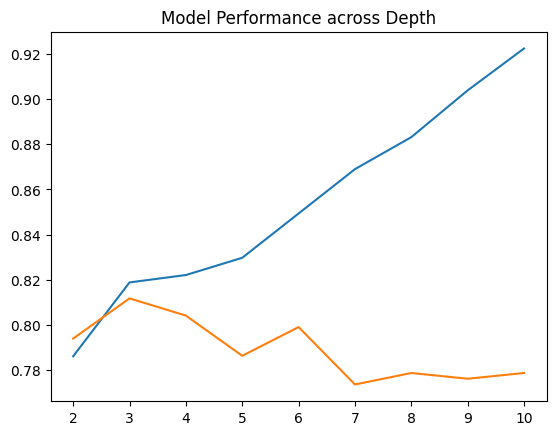

In [13]:
import matplotlib.pyplot as plt

depths = list(range(2,11))
train_accs = []
test_accs = []
for depth in depths:
  clf = tree.DecisionTreeClassifier(max_depth = depth)
  clf.fit(X_train, y_train)
  accuracy = accuracy_score(y_train, clf.predict(X_train))
  test_acc = accuracy_score(y_test, clf.predict(X_test))
  train_accs.append(accuracy)
  test_accs.append(test_acc)

fig, ax = plt.subplots()
ax.plot(depths, train_accs)
ax.plot(depths, test_accs)
ax.set_title('Model Performance across Depth')
fig.show()


##### Visualizing the Tree

One useful thing we can do is actually visualize our decision tree model! We can use the [graphViz](https://www.graphviz.org/) library to accomplish this:

Accuracy:  81.87772925764192 %


[Text(0.5, 0.875, 'sex <= 0.5\ngini = 0.474\nsamples = 916\nvalue = [563, 353]'),
 Text(0.25, 0.625, 'pclass <= 2.5\ngini = 0.396\nsamples = 335\nvalue = [91.0, 244.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'fare <= 31.681\ngini = 0.142\nsamples = 182\nvalue = [14, 168]'),
 Text(0.0625, 0.125, 'gini = 0.237\nsamples = 80\nvalue = [11, 69]'),
 Text(0.1875, 0.125, 'gini = 0.057\nsamples = 102\nvalue = [3, 99]'),
 Text(0.375, 0.375, 'fare <= 23.35\ngini = 0.5\nsamples = 153\nvalue = [77, 76]'),
 Text(0.3125, 0.125, 'gini = 0.489\nsamples = 131\nvalue = [56, 75]'),
 Text(0.4375, 0.125, 'gini = 0.087\nsamples = 22\nvalue = [21, 1]'),
 Text(0.75, 0.625, 'age <= 9.5\ngini = 0.305\nsamples = 581\nvalue = [472, 109]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'sibsp <= 2.5\ngini = 0.494\nsamples = 27\nvalue = [12, 15]'),
 Text(0.5625, 0.125, 'gini = 0.117\nsamples = 16\nvalue = [1, 15]'),
 Text(0.6875, 0.125, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]'),
 Text(0.875, 0.3

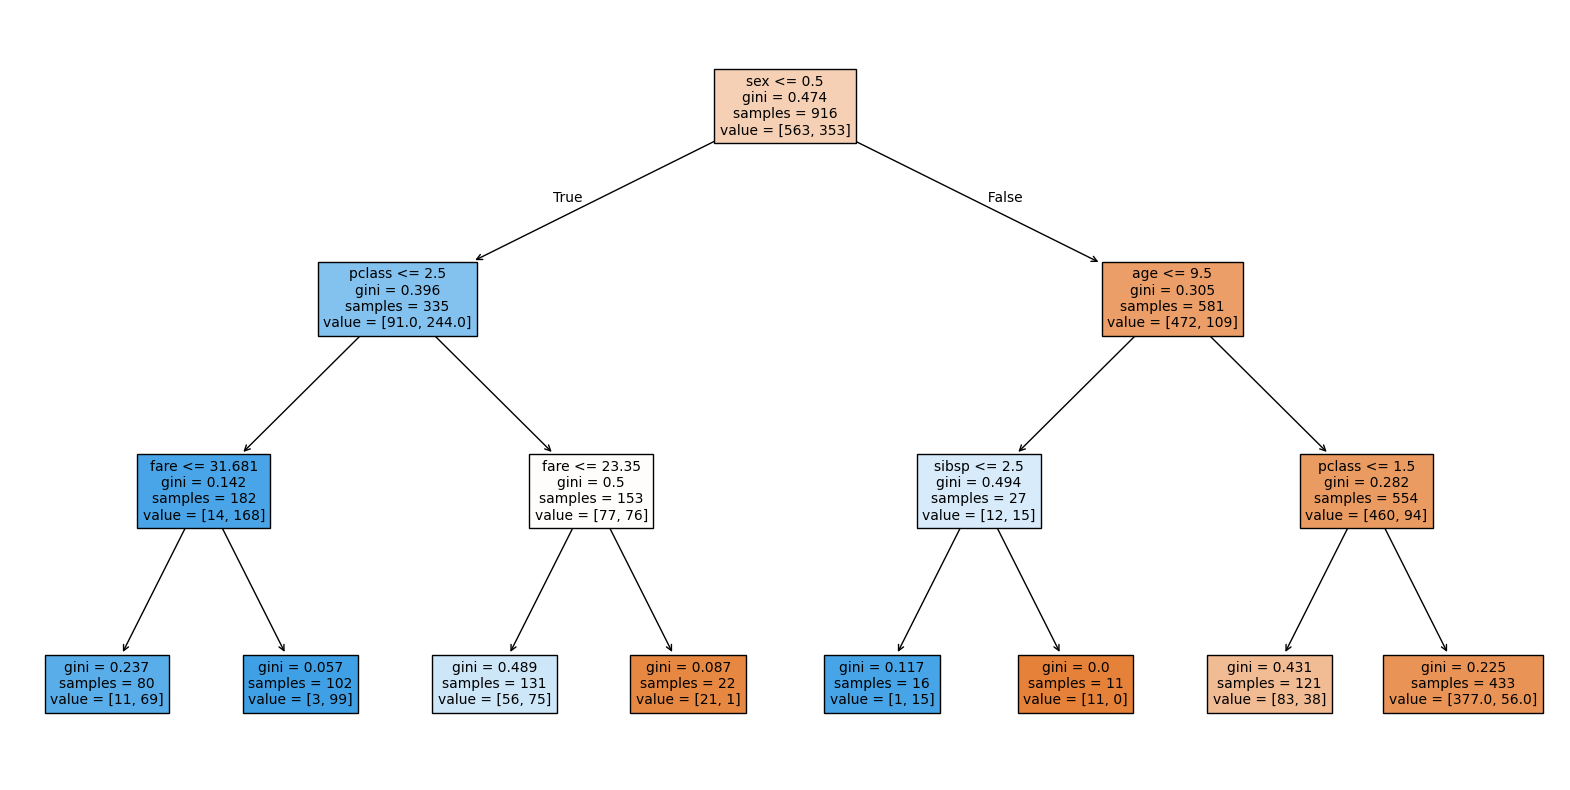

In [14]:
from sklearn.tree import export_graphviz

clf = tree.DecisionTreeClassifier(max_depth = 3)

clf.fit(X_train, y_train)

accuracy = accuracy_score(y_train, clf.predict(X_train))
print ("Accuracy: ", accuracy * 100, "%")

from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=data.columns.drop('survived'), fontsize=10) # Plot the tree

Lets explore the decision tree and answer the following:
* What feature does the root node split on?
* What features appear most in the tree?

##### HP Tuning
There are many hyper-parameters that can be tuned to change how the model performs. Some common parameters that are modified include:
1. Max Tree Depth: How "tall" do you want your tree to be
2. Minimum Samples Per Leaf: This parameter defines the minimum number of training datapoints that fall into a given leaf node in order for that node to be created
3. Minimum Samples to Split: This parameter controls the minimum number of samples required to create a decision split

To decide the values of each of the parameters, we can use Grid Search combined with cross validation. In Grid Search, we first decide what potential values we want each hyperparameter will take. Then we find every possible combination of parameters and run cross validation on each combination to estimate the performance of that hyperparameter combination.

Luckily, `sklearn` has a nice implementation of Grid Search that runs this algorithm for us.

Here we want to tune three parameters: max_depth, min_samples_split, and min_samples_leaf. To do this, we need to define possible values we want to search over.


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = tree.DecisionTreeClassifier() # First we define our model without passing in parameters
hyperparameter_search = { # Then we decide the possible parameter combinations
    'max_depth': [2,4,6], ## FILL THIS IN
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2,5,8] ## FILL THIS IN
}
evaluation_metric = make_scorer(accuracy_score, # GridSearchCV requires us to wrap our metric function in a "scorer"
                                greater_is_better = True)

grid_search_cv = GridSearchCV(estimator = clf,
                              param_grid = hyperparameter_search,
                              scoring = evaluation_metric,
                              cv = 5) # Set up search algorithm
grid_search_cv.fit(X_train, y_train) # Run the search. NOTE: This may take a while

print("Best Parameters: ", grid_search_cv.best_params_) # Print the parameters
print ("Best CV Accuracy: ", grid_search_cv.best_score_ * 100, "%")

clf = grid_search_cv.best_estimator_ # Get the best model from the GridSearch
accuracy = accuracy_score(y_test, clf.predict(imp.transform(X_test)))
print ("Testing Accuracy: ", accuracy * 100, "%") # Print the testing accuracy of the best model

Best Parameters:  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV Accuracy:  80.89213589926348 %
Testing Accuracy:  80.91603053435115 %


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In the cell above, we tested our three values per hyperparameter and ran grid search to find the best combination from the space we defined. As you may have noticed, the number of combinations tested by Grid Search exponentially increases as you test more values and tune more hyperparameters. This means that performing a grid search is often a task that takes a long period of time and is often **not** used for more complex models like neural networks.

### Other Models
If you have finished early, feel free to try other models and try to get as high of a test accuracy as you can!

Some other models you can start with:
1. [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
3. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

You can also use models from other packages. Some examples include:
1. [XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html) (you will need to run `!pip install xgboost`)
2. [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) (`!pip install lightgbm`)

